# Explore Dimensionality of Mesh Data for Regression

This notebook performs PCA on the mesh data, to extract the number of dimensions necessary to improve the regression fit.

In [17]:
import src.setcwd

src.setcwd.main()

Working directory:  /home/nmiolane/code/my28brains/src
Directory added to path:  /home/nmiolane/code/my28brains
Directory added to path:  /home/nmiolane/code/my28brains/src
Directory added to path:  /home/nmiolane/code/my28brains/H2_SurfaceMatch
Directory added to path:  /home/nmiolane/code/my28brains/src/notebooks
Directory added to path:  /home/nmiolane/code/my28brains/src/notebooks/csv


In [18]:
import os
import random

import dash_bootstrap_components as dbc
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go  # or plotly.express as px
from dash import Dash, Input, Output, State, callback, dcc, html
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

os.environ["GEOMSTATS_BACKEND"] = "pytorch"  # noqa: E402
import geomstats.backend as gs

import project_pregnancy.default_config as default_config
import src.datasets.utils as data_utils
from src.regression import training

### Load X=hormones and y=meshes

In [19]:
(
    space,
    mesh_sequence_vertices,
    vertex_colors,
    hormones_df,
) = data_utils.load_real_data(default_config)
# Do not include postpartum values that are too low
hormones_df = hormones_df[hormones_df["EndoStatus"] == "Pregnant"]
mesh_sequence_vertices = mesh_sequence_vertices[:9]

n_meshes, n_vertices, _ = mesh_sequence_vertices.shape

X = hormones_df[["estro", "prog", "lh"]].values
_, n_hormones = X.shape
X_mean = X.mean(axis=0)

y = mesh_sequence_vertices.reshape(n_meshes, -1)
y_mean = y.mean(axis=0)
y = y - y_mean

<module 'project_pregnancy.default_config' from '/home/nmiolane/code/my28brains/project_pregnancy/default_config.py'>
Using mesh data from (unsorted) reparameterized directory

Found 25 .plys for (left, -1) in /home/nmiolane/code/my28brains/project_pregnancy/results/1_preprocess/d_reparameterized
Day 15 has no data. Skipping.
DayID not to use: 15
Hormones excluded from day:  15
df index:  RangeIndex(start=0, stop=25, step=1)
Missing days: Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 22, 23, 24], dtype='int64')
space faces: torch.Size([2182, 3])
mesh_sequence_vertices shape: torch.Size([13, 945, 3])
hormones_df shape: (13, 9)


### PCA on y=meshes

First try maximum number of components to plot the explained variance per component.

In [28]:
# Define the number of principal components
n_components = 9  # Adjust based on variance explanation
pca = PCA(n_components=n_components)
y_pca = pca.fit_transform(y)

In [53]:
def plot_cumulative_variance(pca):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, len(cumulative_variance) + 1),
            y=cumulative_variance,
            mode="lines+markers",
            marker=dict(size=8),
            line=dict(width=2),
        )
    )

    fig.update_layout(
        title="Cumulative Explained Variance by PCA Components",
        xaxis_title="Number of Components",
        yaxis_title="Explained Variance",
        xaxis=dict(
            tickmode="linear", tick0=1, dtick=1
        ),  # Ensuring x-axis labels start from 1 and increment by 1
        yaxis=dict(
            ticksuffix="", range=[0, 1.05]
        ),  # Adjusting y-axis to show percentage
        showlegend=False,
        width=500,  # Set the width of the figure
        height=400,  # Set the height of the figure
    )
    # Adding a horizontal line at 0.95 for the 95% variance threshold, if needed
    fig.add_shape(
        type="line",
        x0=1,
        y0=0.95,
        x1=len(cumulative_variance),
        y1=0.95,
        line=dict(color="Red", width=2, dash="dash"),
    )

    fig.show()

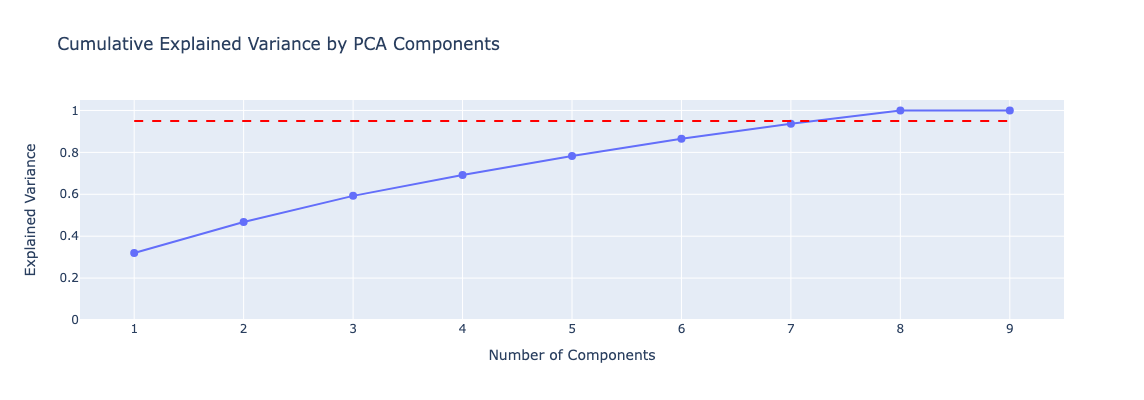

In [54]:
plot_cumulative_variance(pca);

Next, look for the number of components that help the linear regression.

In [78]:
n_components = 3
pca = PCA(n_components=n_components)
y_pca = pca.fit_transform(y)
print(f"N components = {n_components}")
print(f"Var: {np.sum(pca.explained_variance_ratio_)}")

lr = LinearRegression()
lr.fit(X, y_pca)
y_pca_pred = lr.predict(X)
print(f"r2 = {r2_score(y_pca, y_pca_pred)}")
print(f"adjustedr2 = {1 - (1 - r2) * (n_meshes - 1) / (n_meshes - n_hormones - 1)}")

N components = 3
Var: 0.5924341709973004
r2 = 0.5807510150992526
adjustedr2 = 0.030223185720838708


In [93]:
variances = []
r2s = []
adjusted_r2s = []

for n_components in range(1, 10):
    pca = PCA(n_components=n_components)
    y_pca = pca.fit_transform(y)
    variances.append(np.sum(pca.explained_variance_ratio_))

    lr = LinearRegression()
    lr.fit(X, y_pca)
    y_pca_pred = lr.predict(X)
    r2 = r2_score(y_pca, y_pca_pred)
    r2s.append(r2)
    adjusted_r2s.append(1 - (1 - r2) * (n_meshes - 1) / (n_meshes - n_hormones - 1))

In [107]:
def plot_functions(variances, r2s, adjusted_r2s, n):
    fig = make_subplots(rows=1, cols=2, subplot_titles=("r2s", "adjusted_r2s"))

    norm_v = (variances - np.min(variances)) / (np.max(variances) - np.min(variances))
    colors = [
        f"rgba({int(255 * (1-x))}, {int(255 * x)}, 100, 1)" for x in norm_v
    ]  # RGB color interpolation

    fig.add_trace(
        go.Scatter(
            x=n, y=r2s, mode="markers", marker=dict(size=10, color=colors), name="r2s"
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=n,
            y=adjusted_r2s,
            mode="markers",
            marker=dict(size=10, color=colors),
            name="adjusted_r2s",
        ),
        row=1,
        col=2,
    )

    fig.update_xaxes(title_text="n components", row=1, col=1)
    fig.update_yaxes(title_text="r2s", row=1, col=1)
    fig.update_xaxes(title_text="n components", row=1, col=2)
    fig.update_yaxes(title_text="adjusted_r2s", row=1, col=2, range=(-0.1, 0.8))
    fig.update_layout(height=400, width=800, title_text="Color: variance")
    fig.show()

['0.32', '0.47', '0.59', '0.69', '0.78', '0.86', '0.94', '1.00', '1.00']


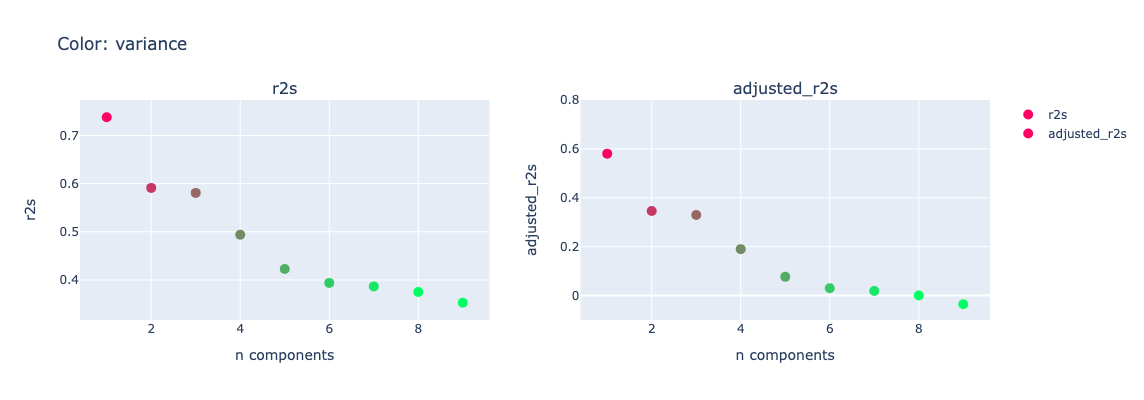

In [108]:
print([f"{v:.2f}" for v in variances])
plot_functions(variances, r2s, adjusted_r2s, list(range(1, 10)))

The number of components, 4, seems like a good compromise between an adjusted R2 that is correct, while explaining 70% of the variance in the data.

### Explore dependency of the first 4 components in each hormones

In [113]:
n_components = 3
pca = PCA(n_components=n_components)
y_pca = pca.fit_transform(y)
print(f"N components = {n_components}")
print(f"Var: {np.sum(pca.explained_variance_ratio_)}")

lr = LinearRegression()
lr.fit(X, y_pca)
y_pca_pred = lr.predict(X)
print(f"r2 = {r2_score(y_pca, y_pca_pred)}")
print(f"adjustedr2 = {1 - (1 - r2) * (n_meshes - 1) / (n_meshes - n_hormones - 1)}")

N components = 3
Var: 0.5924341709973002
r2 = 0.5807510150992524
adjustedr2 = -0.03580246913580254


In [128]:
hormone_names = ["estro", "prog", "LH"]

def plot_xy_relationships(X, y):
    num_x_features = X.shape[1]  # 3 hormones
    num_y_features = y.shape[1]  # number of pcs
    
    fig = make_subplots(
        rows=num_x_features,
        cols=num_y_features,
        subplot_titles=[
            f"{hormone_names[xi]} vs Y{yi}"
            for yi in range(num_y_features)
            for xi in range(num_x_features)
        ],
    )
    for xi in range(num_x_features):
        for yi in range(num_y_features):
            fig.add_trace(
                go.Scatter(
                    x=y[:, yi], y=X[:, xi], mode="markers", name=f"{hormone_names[xi]} vs Y{yi}"
                ),
                row=xi + 1,
                col=yi + 1,
            )
    fig.update_layout(
        height=600,
        width=900,
        title_text="Scatter Plots of Hormones vs Y PCA Dimensions",
    )
    fig.show()

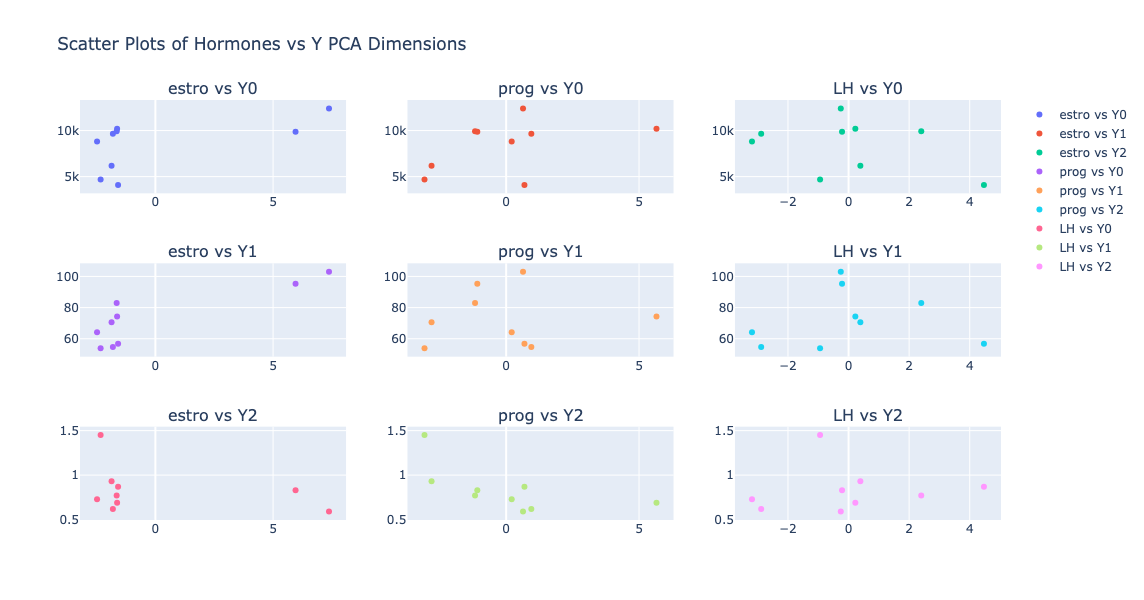

In [129]:
plot_xy_relationships(X, y_pca);

The goal was to see if the trends were linear. We do not see any other type of non-linear trend.